In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,8)})

from statsmodels.tsa.seasonal import STL

from sklearn.ensemble import IsolationForest

## Historical Weather Data for Boulder, CO

In [7]:
raw_df = pd.read_csv('/src/data/weather_data_historical.csv')

# change dt_iso to datetime
# original format: YYYY-MM-DD 00:00:00 +0000 UTC
raw_df['dt_iso'] = raw_df['dt_iso'].str[:-10]
raw_df['dt_iso'] = pd.to_datetime(raw_df['dt_iso'], format='%Y-%m-%d %H:%M:%S')

# just to make sure
raw_df.sort_values('dt_iso', inplace=True)

# set datetime index for later down sample
raw_df.set_index('dt_iso', inplace=True)

#######################################################################
'''
UNITS:
temp_min / temp_max - the min and max temps at the moment
timezone - shift in seconds from UTC
temp - C
visibility - m
dew_point - kelvin
feels like - C
pressure - hPA
humidity - %
wind_speed - m/s
wind_deg - deg (meteorological)
wind_gust - m/s
rain_1h - mm
snow_1h - mm
clouds_all - %
weather_id - weather condition id
weather_main - group of weather parameters (rain, snow, extreme)
''';

In [8]:
# drop columns with all null values
raw_df.drop(
    columns=[
        'sea_level', 
        'grnd_level', 
        'snow_3h', 
        'rain_3h'
    ], inplace=True
)

# drop unneeded columns
raw_df.drop(
    columns=[
        'dt', 
        'timezone', 
        'city_name', 
        'lat', 
        'lon', 
        'clouds_all', 
        'weather_id', 
        'weather_main', 
        'weather_description',
        'weather_icon'
    ], inplace=True
)

In [9]:
# handle null values

# fill NaN for snow and rainfall with 0
raw_df[['rain_1h', 'snow_1h']] = raw_df[['rain_1h', 'snow_1h']].fillna(float(0))

In [10]:
# no null values
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378309 entries, 1979-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   temp        378309 non-null  float64
 1   visibility  101498 non-null  float64
 2   dew_point   378309 non-null  float64
 3   feels_like  378309 non-null  float64
 4   temp_min    378309 non-null  float64
 5   temp_max    378309 non-null  float64
 6   pressure    378309 non-null  int64  
 7   humidity    378309 non-null  int64  
 8   wind_speed  378309 non-null  float64
 9   wind_deg    378309 non-null  int64  
 10  wind_gust   26888 non-null   float64
 11  rain_1h     378309 non-null  float64
 12  snow_1h     378309 non-null  float64
dtypes: float64(10), int64(3)
memory usage: 40.4 MB


In [11]:
# select columns we will use for our analysis
cols = [
    'temp',
    'rain_1h',
    'snow_1h',
]

# select aggregations to down sample features
aggs = {
    'temp': 'mean',
    'rain_1h': 'sum',
    'snow_1h': 'sum'
}


# select column names for after aggregations
names = {
    'temp': 'mean_temp',
    'rain_1h': 'rain_total',
    'snow_1h': 'snow_total'
}

In [12]:
# create copy of raw_df and downsample hourly -> daily
df = raw_df[cols].resample('D').agg(aggs).rename(columns=names)

# add additional columns for max and min temp of each day
df['max_temp'] = raw_df['temp'].resample('D').max()
df['min_temp'] = raw_df['temp'].resample('D').min()

In [13]:
df.head()

,mean_temp,rain_total,snow_total,max_temp,min_temp
dt_iso,,,,,
1979-01-01,-20.025000,0.0,0.73,-16.33,-23.03
1979-01-02,-15.195833,0.0,0.00,-5.64,-22.49
1979-01-03,-10.642083,0.0,0.00,-3.28,-16.55
1979-01-04,-11.774167,0.0,0.00,-6.76,-16.72
1979-01-05,-15.053333,0.0,0.11,-9.85,-19.02


In [14]:
# create additional date columns for future analysis
df['year'] = df.index.year
df['month_name'] = df.index.month_name()
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['day_of_year'] = df.index.strftime('%j')

In [15]:
# reorder columns for clarity
cols_reorder = [
    'year', 
    'month_name', 
    'month', 
    'day_of_month', 
    'day_of_year', 
    'max_temp', 
    'min_temp'
] + list(names.values())

df = df[cols_reorder]

In [16]:
df.head()

,year,month_name,month,day_of_month,day_of_year,max_temp,min_temp,mean_temp,rain_total,snow_total
dt_iso,,,,,,,,,,
1979-01-01,1979,January,1,1,001,-16.33,-23.03,-20.025000,0.0,0.73
1979-01-02,1979,January,1,2,002,-5.64,-22.49,-15.195833,0.0,0.00
1979-01-03,1979,January,1,3,003,-3.28,-16.55,-10.642083,0.0,0.00
1979-01-04,1979,January,1,4,004,-6.76,-16.72,-11.774167,0.0,0.00
1979-01-05,1979,January,1,5,005,-9.85,-19.02,-15.053333,0.0,0.11


In [17]:
df.describe()

,year,month,day_of_month,max_temp,min_temp,mean_temp,rain_total,snow_total
count,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000,15706.000000
mean,2000.000000,6.522858,15.729848,14.928995,1.019455,7.155273,1.722560,0.661801
std,12.410238,3.448833,8.800461,10.137916,8.806356,9.555276,4.378536,2.915628
min,1979.000000,1.000000,1.000000,-23.720000,-33.680000,-26.452917,0.000000,0.000000
25%,1989.000000,4.000000,8.000000,7.130000,-5.300000,-0.277708,0.000000,0.000000
50%,2000.000000,7.000000,16.000000,15.440000,1.145000,7.094167,0.000000,0.000000
75%,2011.000000,10.000000,23.000000,23.410000,8.420000,15.510640,1.510000,0.000000
max,2021.000000,12.000000,31.000000,39.110000,24.170000,30.244000,98.260000,132.520000


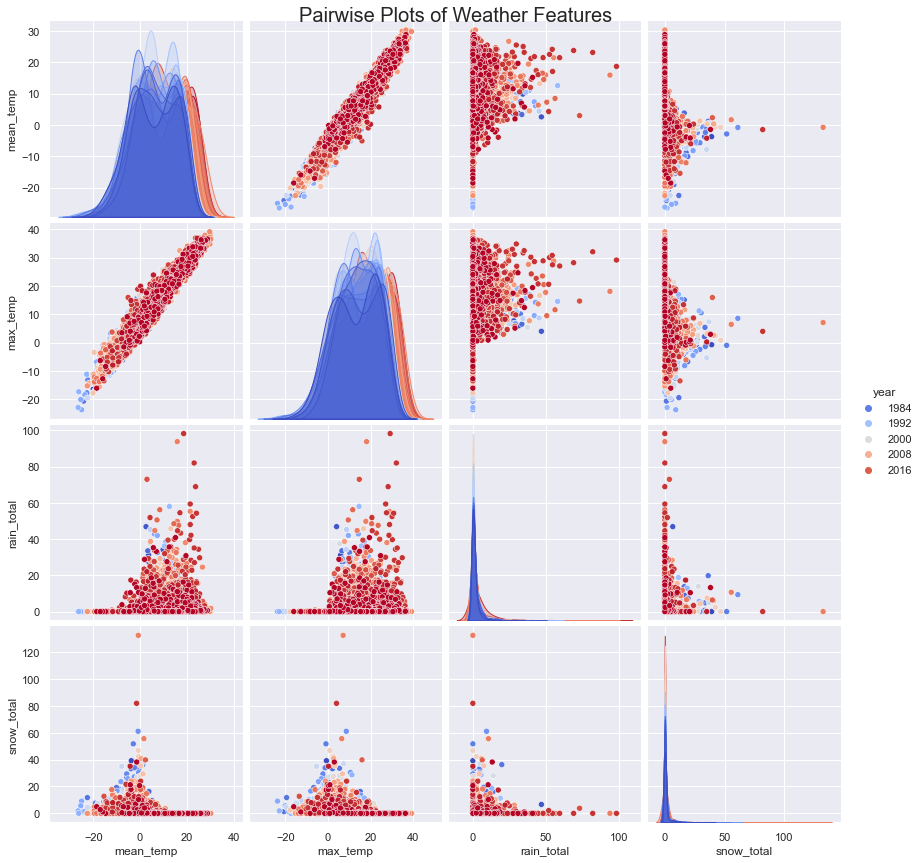

In [18]:
sns.pairplot(
    df,
    height=3,
    vars=[
        'mean_temp',
        'max_temp',
        'rain_total',
        'snow_total',
    ],
    hue='year',
    palette='coolwarm'
)
plt.suptitle('Pairwise Plots of Weather Features', fontsize=20, y=1.0)
plt.show()


<AxesSubplot:>

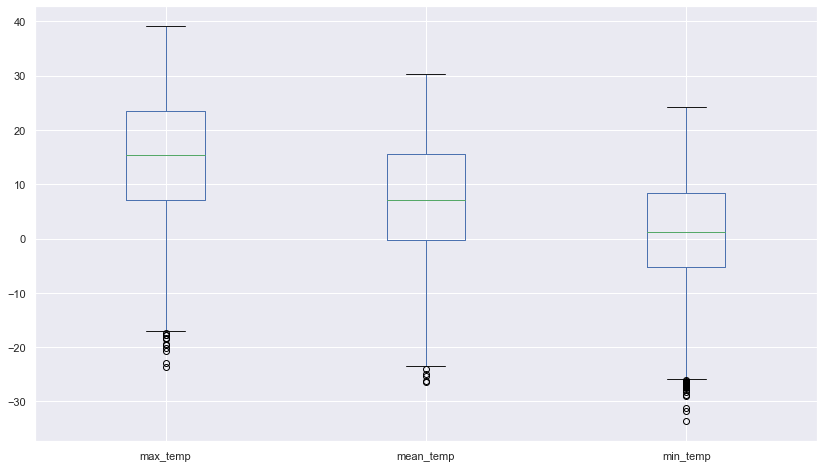

In [19]:
# similar distributions for temperature
df[['max_temp', 'mean_temp', 'min_temp']].plot.box(figsize=(14,8))

In [20]:
# I will use a Seasonal Trend Decomposition - LOESS - to extract trend and seasonality from data
stl = STL(df['mean_temp'])
res = stl.fit()

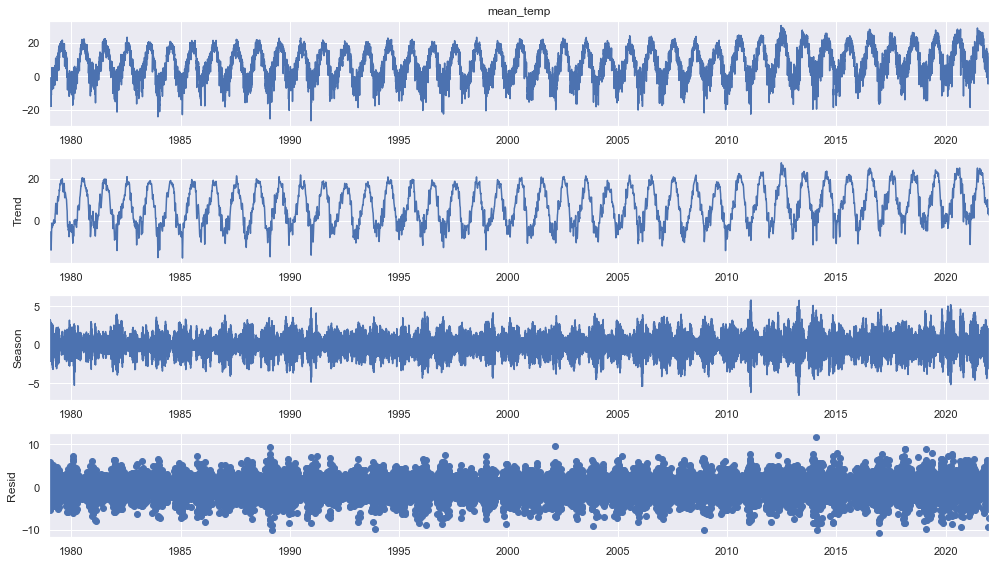

In [21]:
res.plot()
plt.show()

<AxesSubplot:>

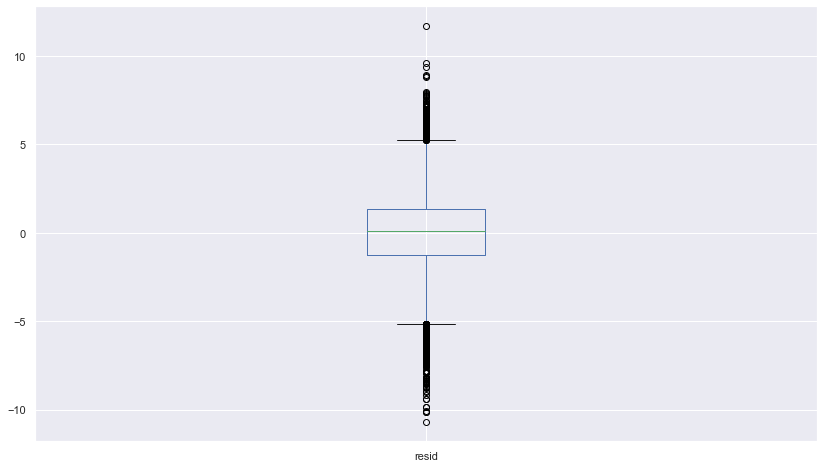

In [22]:
# use only the residual data to detect outliers more accurately, the distribution is more normal
res.resid.plot.box(figsize=(14,8))

In [23]:
# add residuals to dataframe. We will use these to for anomaly labelling
df['LOESS_residuals'] = res.resid

In [24]:
df.head()

,year,month_name,month,day_of_month,day_of_year,max_temp,min_temp,mean_temp,rain_total,snow_total,LOESS_residuals
dt_iso,,,,,,,,,,,
1979-01-01,1979,January,1,1,001,-16.33,-23.03,-20.025000,0.0,0.73,-4.829243
1979-01-02,1979,January,1,2,002,-5.64,-22.49,-15.195833,0.0,0.00,-1.430659
1979-01-03,1979,January,1,3,003,-3.28,-16.55,-10.642083,0.0,0.00,1.168216
1979-01-04,1979,January,1,4,004,-6.76,-16.72,-11.774167,0.0,0.00,-2.371705
1979-01-05,1979,January,1,5,005,-9.85,-19.02,-15.053333,0.0,0.11,-3.984884


## Using an Isolation Forest to Label Anomalies

In [25]:
# build isolation forest model with residual data from max hourly temp each day

isolation_forest = IsolationForest(n_estimators=100, n_jobs=-1, contamination=0.05)
isolation_forest.fit(df['LOESS_residuals'].to_numpy().reshape(-1,1))

IsolationForest(contamination=0.05, n_jobs=-1)

In [26]:
df['iso_forest_anomaly'] = isolation_forest.fit_predict(df['LOESS_residuals'].to_numpy().reshape(-1,1))

In [28]:
# negative scores represent outliers
df['iso_forest_anomaly'].value_counts()

 1    14923
-1      783
Name: iso_forest_anomaly, dtype: int64

<AxesSubplot:xlabel='year'>

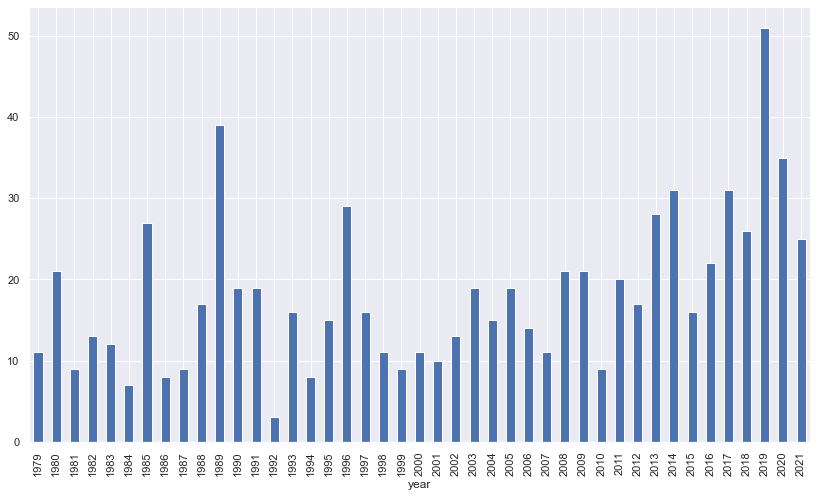

In [29]:
# number of mean temp anomaly days per year
df.loc[df['iso_forest_anomaly']==-1].groupby('year')['mean_temp'].count().plot(kind='bar', figsize=(14,8))

## Using Standard Deviation to Label Outliers

In [30]:
# Standard Deviation for anomaly detection

mean = df['LOESS_residuals'].mean()
std = df['LOESS_residuals'].std()

std_mult = std * 2

lower_limit = mean - std_mult
upper_limit = mean + std_mult

In [31]:
df['STD_anomaly'] = np.where((df['LOESS_residuals'] < lower_limit) | (df['LOESS_residuals'] > upper_limit), True, False)

In [32]:
df['STD_anomaly'].value_counts()

False    14845
True       861
Name: STD_anomaly, dtype: int64

<AxesSubplot:xlabel='year'>

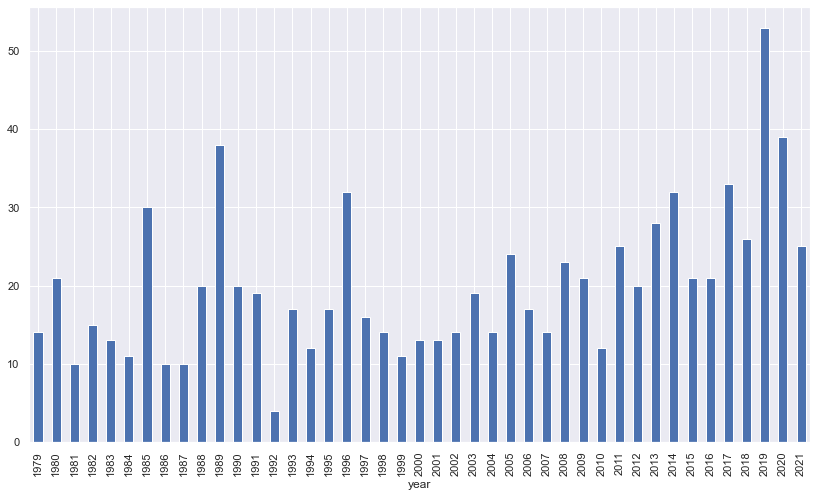

In [33]:
# number of max temp anomaly days per year
df.loc[df['STD_anomaly']==True].groupby('year')['mean_temp'].count().plot(kind='bar', figsize=(14,8))

## Using Inter-Quartile Range to Label Outliers

In [34]:
# IQR for anomaly detection

q1 = df['LOESS_residuals'].quantile(0.25)
q3 = df['LOESS_residuals'].quantile(0.75)
iqr = q3 - q1
lower_bound=(q1 - 1.35 * iqr)
upper_bound=(q3 + 1.35 * iqr)

df['IQR_anomaly'] = np.where((df['LOESS_residuals'] < lower_bound) | (df['LOESS_residuals'] > upper_bound), True, False)

In [35]:
df['IQR_anomaly'].value_counts()

False    15028
True       678
Name: IQR_anomaly, dtype: int64

<AxesSubplot:xlabel='year'>

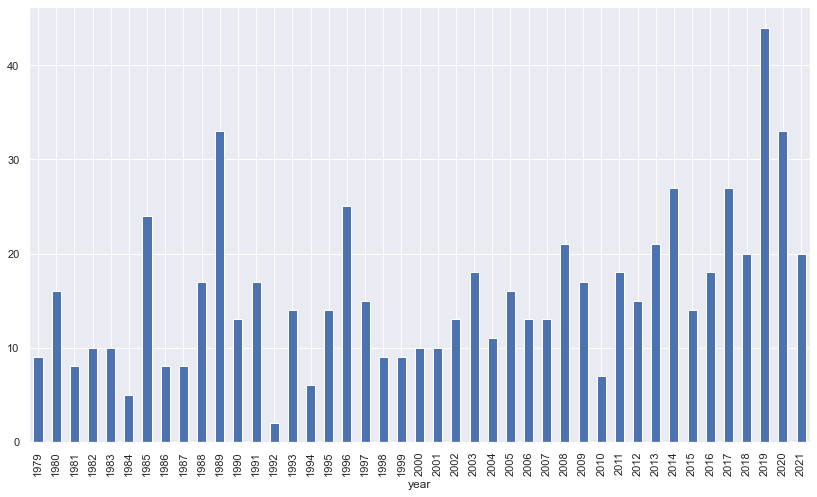

In [36]:
# number of mean temp anomaly days per year
df.loc[df['IQR_anomaly']==True].groupby('year')['mean_temp'].count().plot(kind='bar', figsize=(14,8))

<AxesSubplot:xlabel='year'>

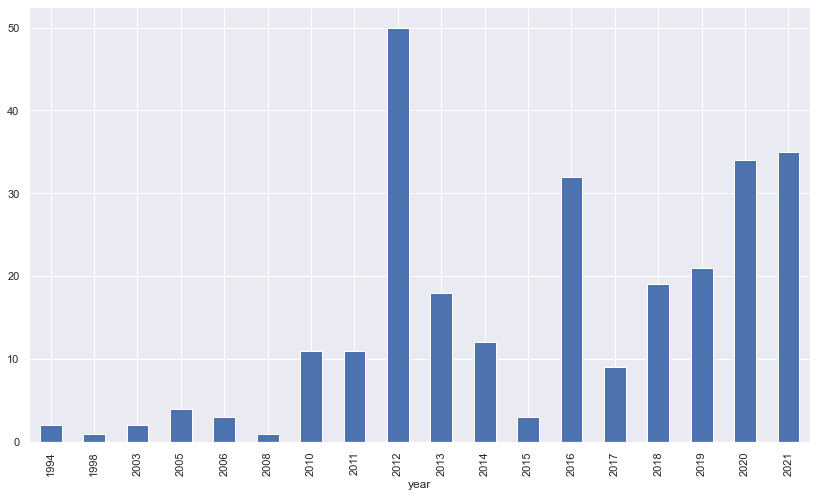

In [37]:
# Days higher than 90deg F per year
df.loc[df['max_temp']>32.2].groupby('year')['max_temp'].count().plot(kind='bar', figsize=(14,8))

## Comparing The Methods Above for Labeling Anomalies

In [38]:
iso_count = df.loc[df['iso_forest_anomaly']==-1].groupby('year')['mean_temp'].count().rename('ISO_FOREST')
std_count = df.loc[df['STD_anomaly']==True].groupby('year')['mean_temp'].count().rename('STD')
IQR_count = df.loc[df['IQR_anomaly']==True].groupby('year')['mean_temp'].count().rename('IQR')

anom_df = pd.concat([iso_count, std_count, IQR_count], axis=1).fillna(0)

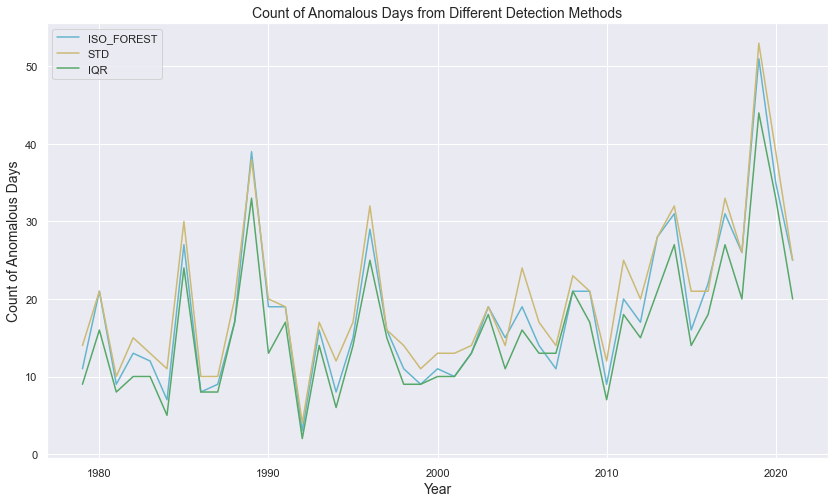

In [39]:
anom_df.plot(figsize=(14,8), color=['c', 'y', 'g'])
plt.title('Count of Anomalous Days from Different Detection Methods', fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Count of Anomalous Days", fontsize=14)
plt.show()

## Closer look at anomalous days with Isolation Forest 

<AxesSubplot:xlabel='month_name'>

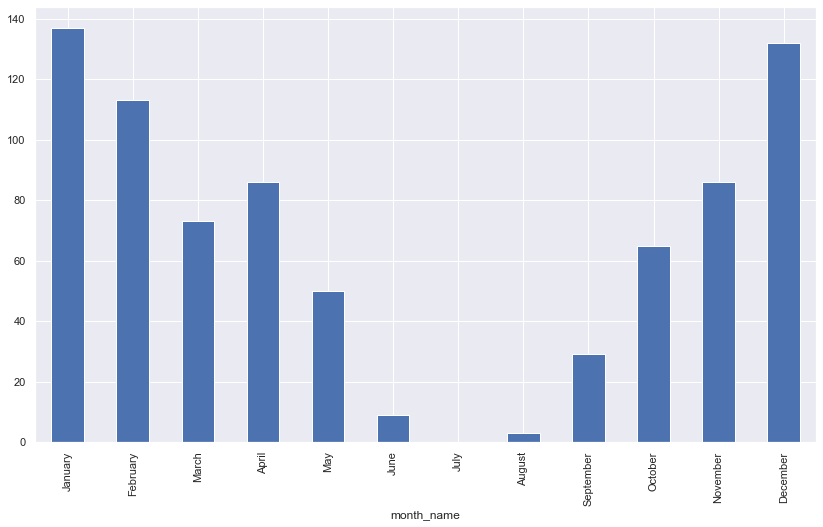

In [40]:
# Which months have the most anomolous days overall?

months = list(calendar.month_name)[1:]
df.loc[df['iso_forest_anomaly']==-1].groupby('month_name')['mean_temp'].count().reindex(months, axis=0).plot(kind='bar', figsize=(14,8))

In [41]:
# this timestamp matches the second highest temp recorded in Boulder in this timeframe (> 1979) 
# highest temp recorded was 2 days earlier on the 23rd, however depending on where this was measured there is variation
# SOURCE - https://www.extremeweatherwatch.com/cities/boulder/highest-temperatures

df.loc[df['max_temp'].idxmax(axis=0)] # 102.39° F

year                       2012
month_name                 June
month                         6
day_of_month                 25
day_of_year                 177
max_temp                  39.11
min_temp                  21.54
mean_temp             29.744167
rain_total                  0.0
snow_total                  0.0
LOESS_residuals        0.565709
iso_forest_anomaly            1
STD_anomaly               False
IQR_anomaly               False
Name: 2012-06-25 00:00:00, dtype: object

In [42]:
df.loc['2012-06-23'] # 100.58° F

year                       2012
month_name                 June
month                         6
day_of_month                 23
day_of_year                 175
max_temp                   38.1
min_temp                  20.03
mean_temp             30.047917
rain_total                  0.0
snow_total                  0.0
LOESS_residuals        3.078894
iso_forest_anomaly            1
STD_anomaly               False
IQR_anomaly               False
Name: 2012-06-23 00:00:00, dtype: object

In [43]:
# lowest mean daily temp in boulder
df.loc[df['mean_temp'].idxmin(axis=0)]

year                       1990
month_name             December
month                        12
day_of_month                 21
day_of_year                 355
max_temp                  -22.9
min_temp                 -28.81
mean_temp            -26.452917
rain_total                  0.0
snow_total                 1.86
LOESS_residuals       -8.477701
iso_forest_anomaly           -1
STD_anomaly                True
IQR_anomaly                True
Name: 1990-12-21 00:00:00, dtype: object

<AxesSubplot:xlabel='year', ylabel='mean_temp'>

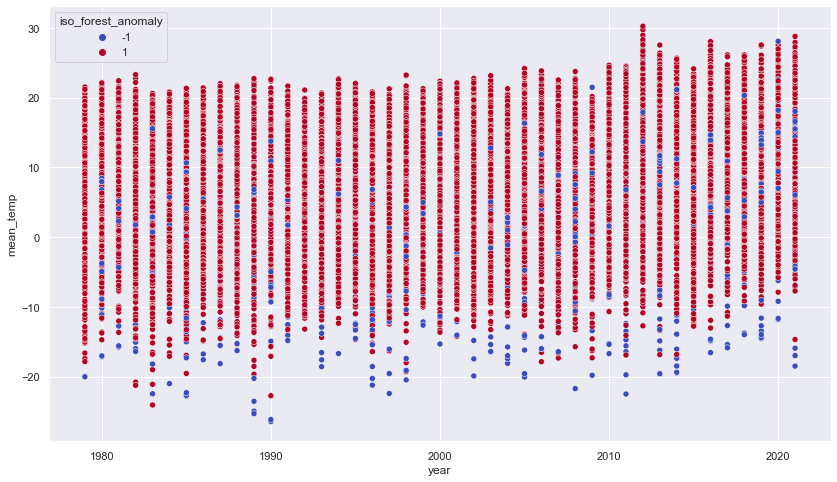

In [44]:
# a scatter visual of outliers
sns.scatterplot(data=df, x='year', y='mean_temp', hue='iso_forest_anomaly', palette='coolwarm')